In [1]:
def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="conv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d(inputconv, o_d, f_w, s_w, padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv

def general_deconv2d(inputconv, outshape, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="deconv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d_transpose(inputconv, o_d, [f_h, f_w], [s_h, s_w], padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv
    
def build_resnet_block(inputres, dim, name="resnet"):
    with tf.variable_scope(name):
        out_res = tf.pad(inputres, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c2",do_relu=False)
        return tf.nn.relu(out_res + inputres)
    

In [2]:
def generator(inputgen, name="generator"):
    with tf.variable_scope(name):
        f = 7
        ks = 3
        ngf = 64

        pad_input = tf.pad(inputgen,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c1 = general_conv2d(pad_input, ngf, f, f, 1, 1, 0.02,name="c1")
        o_c2 = general_conv2d(o_c1, ngf*2, ks, ks, 2, 2, 0.02,"SAME","c2")
        o_c3 = general_conv2d(o_c2, ngf*4, ks, ks, 2, 2, 0.02,"SAME","c3")

        o_r1 = build_resnet_block(o_c3, ngf*4, "r1")
        o_r2 = build_resnet_block(o_r1, ngf*4, "r2")
        o_r3 = build_resnet_block(o_r2, ngf*4, "r3")
        o_r4 = build_resnet_block(o_r3, ngf*4, "r4")
        o_r5 = build_resnet_block(o_r4, ngf*4, "r5")
        o_r6 = build_resnet_block(o_r5, ngf*4, "r6")

        o_c4 = general_deconv2d(o_r6, [1,64,64,ngf*2], ngf*2, ks, ks, 2, 2, 0.02,"SAME","c4")
        o_c5 = general_deconv2d(o_c4, [1,128,128,ngf], ngf, ks, ks, 2, 2, 0.02,"SAME","c5")
        o_c5_pad = tf.pad(o_c5,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c6 = general_conv2d(o_c5_pad, 3, f, f, 1, 1, 0.02,"VALID","c6",do_relu=False)

        # Adding the tanh layer

        out_gen = tf.nn.tanh(o_c6,"t1")


        return out_gen

In [3]:
def discriminator(inputdisc, name="discriminator"):
    with tf.variable_scope(name):
        f = 4
        ndf = 64

        o_c1 = general_conv2d(inputdisc, ndf, f, f, 2, 2, 0.02, "SAME", "c1", do_norm=False, relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf*2, f, f, 2, 2, 0.02, "SAME", "c2", relufactor=0.2)
        o_c3 = general_conv2d(o_c2, ndf*4, f, f, 2, 2, 0.02, "SAME", "c3", relufactor=0.2)
        o_c4 = general_conv2d(o_c3, ndf*8, f, f, 1, 1, 0.02, "SAME", "c4",relufactor=0.2)
        o_c5 = general_conv2d(o_c4, 1, f, f, 1, 1, 0.02, "SAME", "c5",do_norm=False,do_relu=False)

        return o_c5

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt 

train_a_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainA/*.jpg")    
train_b_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainB/*.jpg")    


train_a_queue = tf.train.string_input_producer(train_a_files)
train_b_queue = tf.train.string_input_producer(train_b_files)


image_reader = tf.WholeFileReader()
_, image_a = image_reader.read(train_a_queue)
_, image_b = image_reader.read(train_b_queue)

image_A = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_a),[256,256]),127.5),1)
image_B = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_b),[256,256]),127.5),1)


input_A = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_A")
imggen = generator(input_A)
imgdisc = discriminator(input_A)

disc_loss_A = tf.reduce_mean(tf.squared_difference(imgdisc, 1))

0.967716
0.946108
0.999947
0.999929


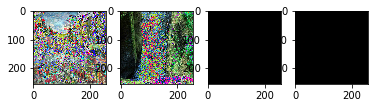

In [5]:
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    # Loading images into the tensors
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    imga = sess.run(image_A).reshape((1, 256, 256, 3))
    imgb = sess.run(image_B).reshape((1, 256, 256, 3))
    imggena = sess.run(imggen, feed_dict={input_A:imga})
    imggenb = sess.run(imggen, feed_dict={input_A:imgb})
    
    print(sess.run(disc_loss_A, feed_dict={input_A:imga}))
    print(sess.run(disc_loss_A, feed_dict={input_A:imgb}))
    print(sess.run(disc_loss_A, feed_dict={input_A:imggena}))
    print(sess.run(disc_loss_A, feed_dict={input_A:imggenb}))

    plt.subplot(141); plt.imshow(imga.reshape((256, 256, 3)))
    plt.subplot(142); plt.imshow(imgb.reshape((256, 256, 3)))
    plt.subplot(143); plt.imshow(imggena.reshape((256, 256, 3)))
    plt.subplot(144); plt.imshow(imggenb.reshape((256, 256, 3)))
    plt.show()
    coord.request_stop()
    coord.join(threads)